# Solve the Moving Sofa Problem with a Neural Network

<a href="https://colab.research.google.com/github/raimonluna/MovingSofa/blob/main/MovingSofa_NeuralNetwork.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Notebook by Raimon Luna (https://github.com/raimonluna). This notebook approximates the solution to the (regular and ambidextrous) Moving Sofa Problem using a simple fully-connected neural network.

For more information, visit:

- https://en.wikipedia.org/wiki/Moving_sofa_problem
- https://mathworld.wolfram.com/MovingSofaProblem.html
- https://www.math.ucdavis.edu/~romik/movingsofa/



In [ ]:
#@markdown #**Licensed under the MIT License**
#@markdown #**(*Double-click to read the license agreement*)**
#@markdown ---

# Copyright (c) 2022 Raimon Luna

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

In [ ]:
#@markdown #**Load libraries**

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from matplotlib import animation
from IPython.display import HTML

%matplotlib inline

In [ ]:
#@markdown #**Define the parameters**
#@markdown ---

ambidextrous  = False #@param {type:"boolean"}

hidden_layers     = 4 #@param {type:"integer"}
neurons_per_layer = 256 #@param {type:"integer"}

random_angles = 20   #@param {type:"integer"}
number_points = 300  #@param {type:"integer"}
train_epochs  = 5000 #@param {type:"integer"}

In [ ]:
#@markdown #**Define and initialize the neural network and optimizer**
#@markdown ---

class Sofa(nn.Module):
    def __init__(self):
        super(Sofa, self).__init__()
        
        self.net = nn.Sequential()
        self.net.add_module('Input', nn.Linear(2, neurons_per_layer))
        self.net.add_module('Input activation', nn.ReLU())

        for l in range(hidden_layers):
            self.net.add_module(f'Hidden {l+1}', nn.Linear(neurons_per_layer, neurons_per_layer))
            self.net.add_module(f'Hidden {l+1} activation', nn.ReLU())
            
        self.net.add_module('Output', nn.Linear(neurons_per_layer, 2))

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.05)
                nn.init.constant_(m.bias, val = 0.0)
                
    def forward(self, phi):
        circle      = torch.cat((1.5*torch.cos(phi), 0.5*torch.sin(phi)), 1)
        input_coord = torch.cat((torch.cos(phi), torch.sin(phi)), 1)
        correction  = self.net(input_coord)
        return circle * (1 + correction)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

arg   = torch.linspace(0, 2*np.pi, number_points).reshape(number_points,1).to(device)
sofa = Sofa().to(device)
relu  = nn.ReLU()
epoch = -1

optimizer = optim.Adam(sofa.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose = False)

Using device: cuda


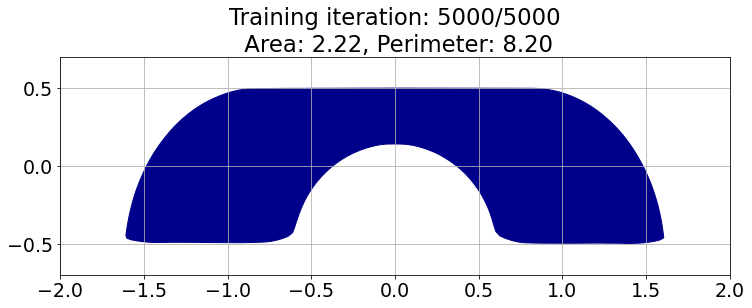

In [ ]:
#@markdown #**Train the model**
#@markdown ---

fig, ax = plt.subplots(1,1, figsize = (12, 4));
plt.rc('font', size = 19)

while epoch <= train_epochs:
    try:
        epoch += 1
        optimizer.zero_grad()

        x  = sofa(arg)
        dx = x - torch.roll(x, 1, dims=0)

        area      = (torch.sum(x[:, 0] * dx[:, 1]) - torch.sum(x[:, 1] * dx[:, 0])) / 2
        perimeter = torch.sum(torch.sqrt(torch.sum(dx**2, axis = 1)))
        length    = torch.max(x[:, 0]) - torch.min(x[:, 0])

        nonunif   = torch.std(torch.sqrt(torch.sum(dx**2, axis = 1)))
        xc        = (torch.max(x[:, 0]) + torch.min(x[:, 0])) / 2
        yc        = (torch.max(x[:, 1]) + torch.min(x[:, 1])) / 2
        
        centering = xc**2 + yc**2
        overlap   = 0

        for theta in torch.rand(random_angles) * np.pi / 2:
            u =   x[:, 0] * torch.cos(theta) + x[:, 1] * torch.sin(theta)
            v = - x[:, 0] * torch.sin(theta) + x[:, 1] * torch.cos(theta)
            overlap += torch.sum(relu(torch.max(u) - 1.0 - u) * relu(torch.max(v) - 1.0 - v)) / random_angles
            overlap += ambidextrous * torch.sum(relu(u - torch.min(u) - 1.0) * relu(v - torch.min(v) - 1.0)) / random_angles 

        weight = 1e-3/scheduler.get_last_lr()[0]
        loss   = 10 * nonunif + weight * (overlap + centering) - area

        loss.backward()
        optimizer.step()

        if epoch %100 == 0:
            display.clear_output(wait=True)
            scheduler.step()

            ax.cla()
            ax.grid()
            ax.set_xlim(-2.,2.)
            ax.set_ylim(-0.7,0.7)

            ax.fill(x[:, 0].cpu().detach().numpy(), x[:, 1].cpu().detach().numpy(), color = 'darkblue')
            ax.set_title(f'Training iteration: {epoch}/{train_epochs}\n Area: {area.item():.2f}, Perimeter: {perimeter.item():.2f}')
            
            display.display(plt.gcf())

    except KeyboardInterrupt:
        break

plt.close()

In [ ]:
#@markdown #**Create video with the moving sofa**
#@markdown ---

x      = sofa(arg).cpu().detach().numpy()
size   = length.item()

x_corridor =  [1, 0, 0, -size, -size, -size, 1]
y_corridor =  [-size, -size, 0, 0, 1, 1, 1]

params_1 = np.vstack([np.zeros(50), np.linspace(0, 1, 50) - size/2, np.ones(50)/2]).transpose()
params_3 = np.vstack([np.pi*np.ones(50)/2,  np.ones(50)/2, 1 - size/2 - np.linspace(0, 1, 50)]).transpose()
params_2 = np.zeros((50, 3))
for i, theta in enumerate(np.linspace(0, np.pi/2, 50)):
    u =   x[:, 0] * np.cos(theta) + x[:, 1] * np.sin(theta)
    v = - x[:, 0] * np.sin(theta) + x[:, 1] * np.cos(theta)
    params_2[i] = [theta, - np.max(u) + 1, - np.max(v) + 1]

if ambidextrous:
    x_corridor += [1, 1+size, 1+size]
    y_corridor += [1-size, 1-size, -size]
    params_4 = params_2[::-1, :] * np.array([1, -1, -1]) + np.array([0, 1, 1 - size])
    params_5 = params_1 + np.array([0, size, -size])
    params   = np.vstack([params_1, params_2, params_3, params_4, params_5])
    ratio = ambidextrous * (2 * size + 1) / (size + 1)
else:
    params   = np.vstack([params_1, params_2, params_3])
    ratio = 1

params = np.vstack([params, params[::-1, :]])
    
fig, ax = plt.subplots(1,1, figsize = (8*ratio,  8))
plt.close()

def animate(i):
    ax.cla()
    ax.axis('off')
    ax.fill(x_corridor, y_corridor, color = 'orange')
    theta, du, dv = params[i]
    u =   x[:, 0] * np.cos(theta) + x[:, 1] * np.sin(theta) + du
    v = - x[:, 0] * np.sin(theta) + x[:, 1] * np.cos(theta) + dv
    ax.fill(u,v, color = 'darkblue')

    return fig

anim = animation.FuncAnimation(fig, animate, frames=len(params), interval=20)
HTML(anim.to_html5_video())